# Vitamin B dependencies

# Imports & Load Individual Models

In [1]:
# basic
import os
import pandas as pd
import re
import numpy as np
import copy

# see functions.py for a collection of self-written functions for analysing and visualising my models
from functions import *

# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from micom import Community

# plots
import matplotlib.pyplot as plt

In [2]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [131]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models_vit = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"_vit")
    models_vit[name] = model

models_vit = {key: models_vit[key] for key in sorted(models_vit.keys())}  # sorts the dictionary alphabetically
AA1_v, AA2_v, AA3_v, AA4_v, AA5_v, AA6_v, AA7_v = [models_vit[f"AA{i}_vit"] for i in range(1, 8)]

# Functions

In [39]:
def get_V8_medium(base_medium, vitamin_list):
    vitamin_med_V8 = base_medium.copy()

    # Make new rows
    new_rows = pd.DataFrame({
        "reaction": vitamin_list,
        "bound": [10] * len(vitamin_list)
    })

    # Concatenate
    vitamin_med_V8 = pd.concat([vitamin_med_V8, new_rows], ignore_index=True)
    return vitamin_med_V8

In [119]:
def vitamin_growth_plots(models, maize_medium, vitamin_list):
    V8_medium = get_V8_medium(maize_medium, vitamin_list)

    # get growth values
    results = []
    for model in models.values():
        growth_V0 = test_medium(model, maize_medium)
        growth_V8 = test_medium(model, V8_medium)
        results.append((model.id, growth_V0, growth_V8))

    # Convert to arrays
    model_ids = [r[0] for r in results]
    growth_V0 = [r[1] for r in results]
    growth_V8 = [r[2] for r in results]


    # Set up positions
    x = np.arange(len(model_ids))
    width = 0.4  # width of bars

    fig, ax = plt.subplots(figsize=(9, 5))

    # Two bar groups
    bars1 = ax.bar(x - width/2, growth_V0, width, label="V0 (No B-Vitamins)", color="lemonchiffon")
    bars2 = ax.bar(x + width/2, growth_V8, width, label="V8 (Full B-Vitamin Mix)", color="cornflowerblue")

    # Add labels and formatting
    ax.set_ylabel("Growth \n[mmol/(gDW h)]")
    ax.set_xlabel("Strain")
    ax.set_title("Growth comparison with and without all B vitamins")
    ax.set_xticks(x)
    strain_codes = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]
    ax.set_xticklabels(strain_codes, rotation=45)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    # annotate bars with values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{height:.2f}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()

In [120]:
# Plot V1 & V7 Experiments
def plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_vx, vitamins, mode):

    # Combine all values
    all_growth = [growth_val_without, growth_val_v8] + growth_vals_vx

    # Numeric positions for bars
    x = np.arange(len(all_growth))

    # Create barplot
    plt.figure(figsize=(10, 6))
    if mode == "V1":
        bars = plt.bar(x, all_growth, color=["lemonchiffon"])
    elif mode =="V7":
        bars = plt.bar(x, all_growth, color=["cornflowerblue"])
        vitamins = ["V8 - "+vitamin for vitamin in vitamins]
    else:
        raise ValueError("mode must be either 'V1' or 'V7'")

    # Labeling
    plt.ylabel("Growth \n[mmol/(gDW h)]")
    plt.xlabel("Added B Vitamins")
    plt.title(f"{mode} Experiments: Growth under different media conditions for {model.id}")

    # Add values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
                 ha="center", va="bottom", fontsize=8)

    # Set x-axis labels properly under each bar
    all_labels = ["V0", "V8"] + vitamins
    plt.xticks(x, all_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# V1 Experiments
def get_v1_growth(model, mode, list_carbon_source, list_of_vitamins, extra_vitamin_names=None):
    # add single carbon source to minimal media
    carbon_sources = pd.DataFrame({"reaction": list_carbon_source, "bound": [10]*len(list_carbon_source)})
    basic_med = pd.concat([m9, carbon_sources], ignore_index=True)

    # Full vitamin medium (V8)
    med_V8 = get_V8_medium(basic_med, list_of_vitamins)

    with model:
        growth_val_without = test_medium(model, basic_med)
        growth_val_v8 = test_medium(model, med_V8)

    growth_vals_v1 = []
    vitamin_names = []
    for vitamin in list_of_vitamins:
        vitamin_name = list(model.reactions.get_by_id(vitamin).metabolites.keys())[0].name if vitamin in model.reactions else vitamin
        vitamin_names.append(vitamin_name)

        vitamin_med = basic_med.copy()

        new_row = pd.DataFrame([{"reaction": vitamin, "bound": 10}])
        vitamin_med = pd.concat([vitamin_med, new_row], ignore_index=True)

        with model:
            growth_val_v1 = test_medium(model, vitamin_med)
            growth_vals_v1.append(growth_val_v1)

    if extra_vitamin_names is not None:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_v1, extra_vitamin_names, mode)
    else:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_v1, vitamin_names, mode)

In [121]:
# V7 Experiments
def get_v7_growth(model, mode, list_carbon_source, list_of_vitamins, extra_vitamin_names=None):
    # Add single carbon source to minimal media
    carbon_sources = pd.DataFrame({"reaction": list_carbon_source, "bound": [10]*len(list_carbon_source)})
    basic_med = pd.concat([m9, carbon_sources], ignore_index=True)

    # Full vitamin medium (V8)
    med_V8 = get_V8_medium(basic_med, list_of_vitamins)

    with model:
        growth_val_without = test_medium(model, basic_med)  # basic medium
        growth_val_v8 = test_medium(model, med_V8)          # all vitamins

    growth_vals_drop = []
    dropped_vitamin_names = []

    # Drop one vitamin at a time
    for vitamin in list_of_vitamins:
        # Medium with all vitamins except the current one
        vitamin_med = med_V8[~med_V8['reaction'].isin([vitamin])].copy()

        # Get human-readable vitamin name
        vitamin_name = list(model.reactions.get_by_id(vitamin).metabolites.keys())[0].name \
                       if vitamin in model.reactions else vitamin
        dropped_vitamin_names.append(vitamin_name)

        with model:
            growth_val = test_medium(model, vitamin_med)
            growth_vals_drop.append(growth_val)

    # Plot
    if extra_vitamin_names is not None:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_drop, extra_vitamin_names, mode)
    else:
        plot_v1_v7_growth(model, growth_val_without, growth_val_v8, growth_vals_drop, dropped_vitamin_names, mode)


# Medium

In [3]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9_rxn = list(m9["reaction"])


medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach = pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')


ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]
ecoplate_short = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon_shortened.csv", sep=";", quotechar='"')
ecoplate_rxns_short = [safe_parse(x) for x in ecoplate_short["reaction"]]

# Create Community

In [4]:
taxonomy = pd.read_csv("../Datasets/community_model_gap_filled.csv", sep=";")
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

# change the lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

# B Vitamins in Our Models & Full Vitamin Medium
I already checked the B vitamins in my 04_Simulations ipynb; AA1, AA5 are missing B12 and AA7 is missing B7 in the model

B1 - Thiamine (C12H17N4OS+) \
BIGG: thm (thiamine), thmmp (Thiamin monophosphate), thmpp (Thiamin diphosphate, active version in body)

B2 - Riboflavin (C17H20N4O6) \
BIGG: ribflv

B3 - Niacin (nicotinic acid)/Niacinamide/Nicotinamide riboside \
--> can be converted into NAD \
BIGG: ncam (Nicotinaminde), nac (Nicotinate), rnam (Ribosylnicotinamide)

B5 - Pantothenic acid (C9H17NO5) \
BIGG: pnto__R (R-pantothenate)

B6 - Pyridoxine/Pyridoxal/Pyridoxamine \
BIGG: pydxn/pydx/pydam

B7 - Biotin (C10H16N2O3S) \
BIGG: btn (biotin)

B9 - Folate (C19H19N7O6) \
BIGG: fol (folate), 5mthf (5-Methyltetrahydrofolate, active form)

B12 - Cobalamin (C63H88CoN14O14P) \
BIGG: b12 (vitamin b12), C06453 (methylcobalamin), adocbl (adenosylcobalamin), adocbi (Adenosyl cobinamide)

In [35]:
Bvitamins = {
    "B1": ["thm", "thmmp", "thmpp"],
    "B2": ["ribflv"],
    "B3": ["ncam", "nicnt", "nac", "rnam"],
    "B5": ["pnto__R"],
    "B6": ["pydam", "pydxn", "pydx"],
    "B7": ["btn"],
    "B9": ["fol", "5mthf"],
    "B12": ["b12", "adocbl", "C06453", "adocbi"]
}

In [36]:
EX_V8 = ["EX_thm_e", "EX_ribflv_e", "EX_nac_e", "EX_rnam_e", "EX_pnto__R_e", "EX_pydxn_e", "EX_btn_e", "EX_fol_e"]
EX_V8_names = ["Thiamin", "Riboflavin", "Niacin", "Ribosylnicotinamide", "Pantothenic acid", "Pyridoxine", "Biotin", "Folate"]
# nac and rnam both B3

carbon sources that were provided as medium in Krumbach

In [37]:
medium_for_vitaminTesting = pd.read_csv("../Datasets/Medium/Carbon_M9_forVitaminTesting.csv", sep=";", quotechar='"')
# 20 diff carbon sources and M9

# V8 - Full Vitamin Mix
see Krumbach, Fig 5a

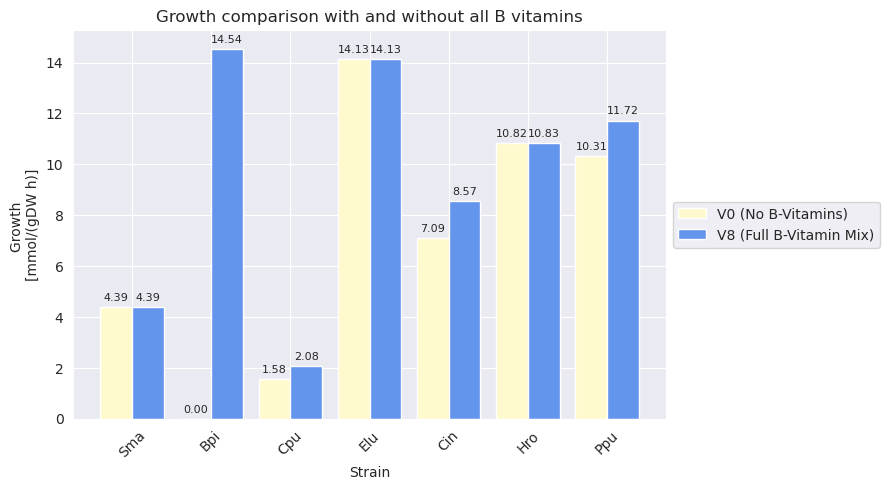

In [43]:
vitamin_growth_plots(models, medium_for_vitaminTesting, EX_V8)

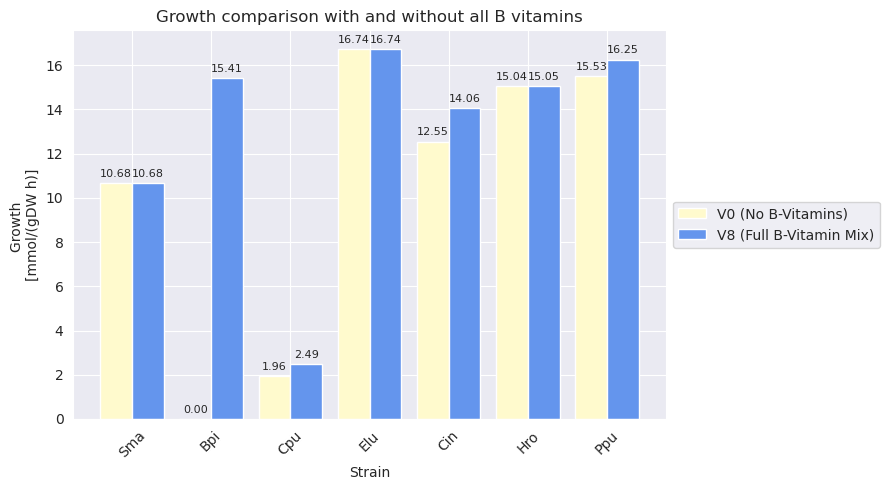

In [44]:
vitamin_growth_plots(models, medium_combined_krumbach, EX_V8)

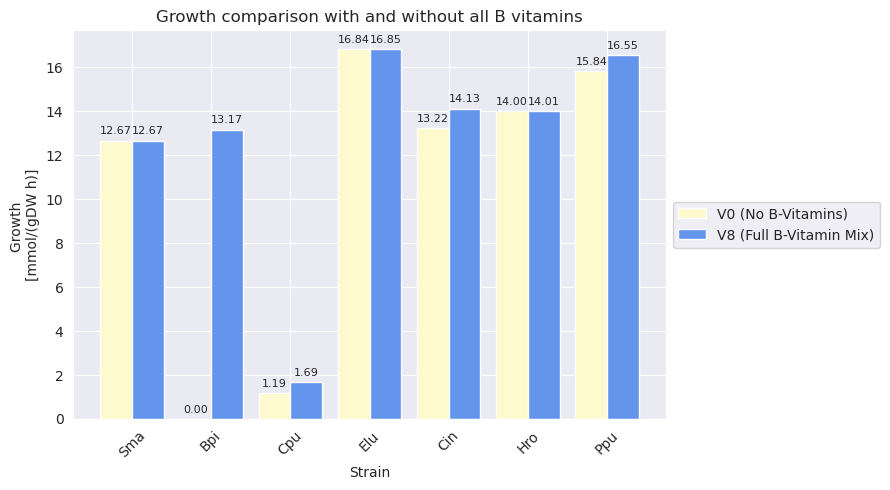

In [45]:
vitamin_growth_plots(models, medium_combined_naveed, EX_V8)

# V1 & V7 - adding one or removing one vitamin
see Krumbach, Figure 6a and 6b

In [46]:
# adding one Vitamin at a time (on Krumbach Medium)
for model in models.values():
    print(model.id)
    for vitamin in EX_V8:
        vitamin_med = medium_combined_krumbach.copy()

        new_row = pd.DataFrame([{"reaction": vitamin, "bound": 10}])
        vitamin_med = pd.concat([vitamin_med, new_row], ignore_index=True)

        with model:
            growth_val = test_medium(model, vitamin_med)
            print(vitamin, growth_val)

    growth_val = test_medium(model, medium_combined_krumbach)
    print("V0", growth_val)

AA1
EX_thm_e 10.684004015899333
EX_ribflv_e 10.684004015899259
EX_nac_e 10.684004015899259
EX_rnam_e 10.684004015899259
EX_pnto__R_e 10.684004015899259
EX_pydxn_e 10.684004015899259
EX_btn_e 10.684004015899259
EX_fol_e 10.684004015899259
V0 10.684004015899259
AA2
EX_thm_e 15.403172919962325
EX_ribflv_e 0.0
EX_nac_e 0.0
EX_rnam_e 0.0
EX_pnto__R_e 0.0
EX_pydxn_e 0.0
EX_btn_e 0.0
EX_fol_e 0.0
V0 0.0
AA3
EX_thm_e 1.9585387730515866
EX_ribflv_e 1.9584272055034517
EX_nac_e 1.9584272055034397
EX_rnam_e 1.958427205503451
EX_pnto__R_e 1.958427205503448
EX_pydxn_e 2.490236623201395
EX_btn_e 1.9584272055034497
EX_fol_e 1.9588623908368592
V0 1.9584272055034555
AA4
EX_thm_e 16.736237910570956
EX_ribflv_e 16.735081796546638
EX_nac_e 16.736378025802047
EX_rnam_e 16.740844352865036
EX_pnto__R_e 16.73540953352886
EX_pydxn_e 16.735081796546574
EX_btn_e 16.735081796546584
EX_fol_e 16.735081796546588
V0 16.735081796546584
AA5
EX_thm_e 12.547903955941692
EX_ribflv_e 12.546695393311582
EX_nac_e 12.546695393

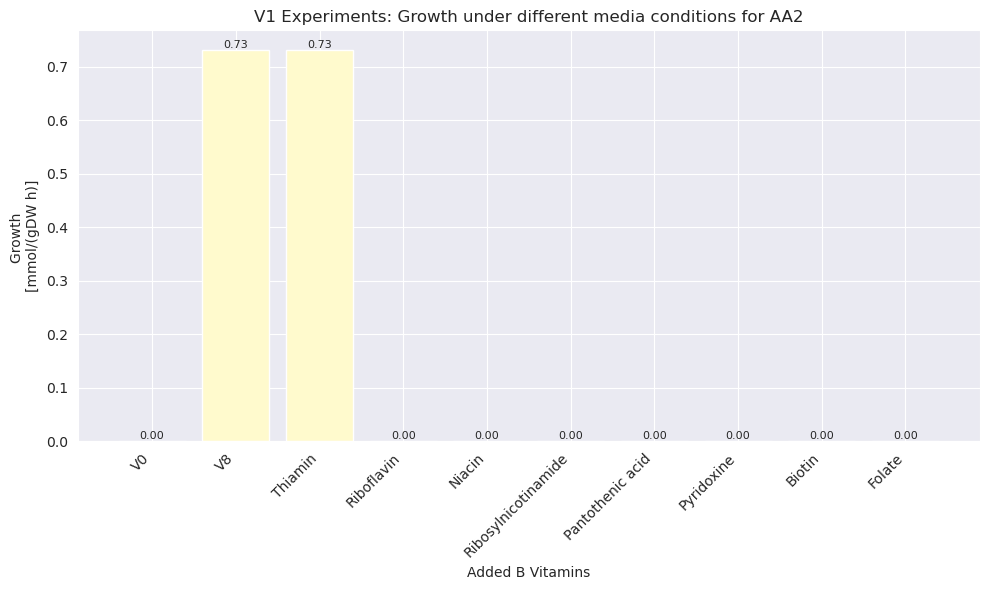

In [47]:
# V1 for Bbi with Alanine as carbon source (+ M9)
ala = ["EX_ala__L_e","EX_ala__D_e","EX_ala_B_e"]
get_v1_growth(AA2, "V1", ala, EX_V8, EX_V8_names)

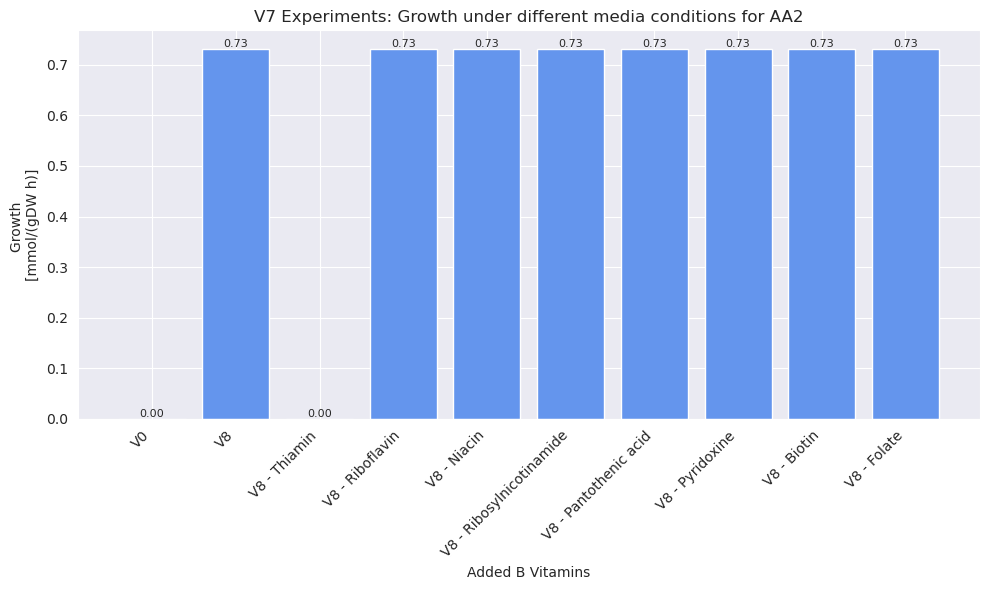

In [48]:
get_v7_growth(AA2, "V7", ala, EX_V8, EX_V8_names)

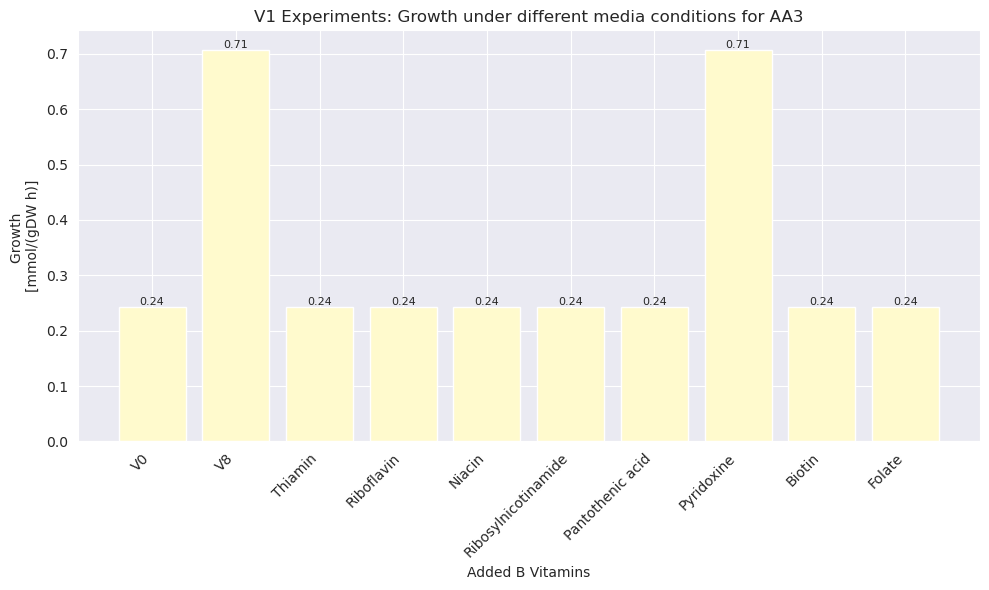

In [61]:
# V1 for Cpu with Glucose as carbon source (+ M9)
glu = ["EX_glc__D_e"]
get_v1_growth(AA3, "V1", glu, EX_V8, EX_V8_names)

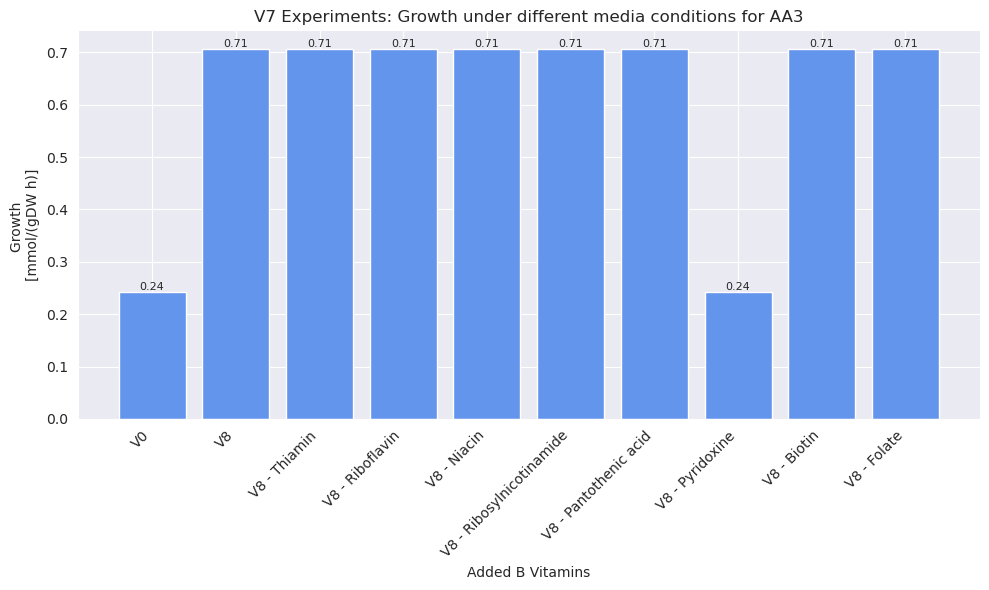

In [62]:
get_v7_growth(AA3, "V7", glu, EX_V8, EX_V8_names)

# Investigations

In [56]:
get_met(AA2, "btn_e")

Biotin (C10H15N2O3S)
{'EX_btn_e': 'btn_e <=> ', 'BTNt': 'atp_c + btn_e + h2o_c --> adp_c + btn_c + h_c + pi_c', 'BTNTe': 'btn_c <=> btn_e', 'BTNt2i': 'btn_e + h_e --> btn_c + h_c'}


In [59]:
get_met(AA2, "btn_c")

Biotin (C10H15N2O3S)
{'BTS3r': 'dtbt_c + 2.0 s_c <=> btn_c + h2s_c', 'BTNTe': 'btn_c <=> btn_e', 'BTS4': 'amet_c + dtbt_c + s_c --> btn_c + dad_5_c + h_c + met__L_c', 'BTNt2i': 'btn_e + h_e --> btn_c + h_c', 'BTNt': 'atp_c + btn_e + h2o_c --> adp_c + btn_c + h_c + pi_c'}


In [60]:
get_rxn(AA2, "BTS3r") # biotin synthase

BTS3r: dtbt_c + 2.0 s_c <=> btn_c + h2s_c


In [ ]:
# there cant really be anything done with biotin, so it cant improve growth at the moment; however as we can see, for AA2 it is also not necessary for growth
# http://bigg.ucsd.edu/models/universal/metabolites/btamp
# http://bigg.ucsd.edu/models/Recon3D/reactions/BTNPL
# http://bigg.ucsd.edu/models/Recon3D/reactions/BACCL
# these could be used for gapfilling (are not in my models whatsoever), BTNPL also would need modifications before implementing

In [63]:
get_met(AA3, "btn_c")

Biotin (C10H15N2O3S)
{'BTNt2i': 'btn_e + h_e --> btn_c + h_c', 'BTNTe': 'btn_c <=> btn_e'}


In [66]:
get_met_unknown(models, "ribflv_e")

ribflv_e (Riboflavin C17H20N4O6 (C17H20N4O6, 0)) is found  models: ['AA2'] and in reactions: {'EX_ribflv_e', 'RIBFLVt2'}


In [69]:
get_met_unknown(models, "pnto__R_c")

pnto__R_c ((R)-Pantothenate (C9H16NO5, -1)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'PNTK', 'PANTS', 'PNTOt4pp'}


In [70]:
get_rxn_unknown(models, "PNTK")

PNTK is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
PNTK: atp_c + pnto__R_c --> 4ppan_c + adp_c + h_c


In [71]:
get_rxn_unknown(models, "PANTS")

PANTS is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
PANTS: ala_B_c + atp_c + pant__R_c --> amp_c + h_c + pnto__R_c + ppi_c


In [87]:
get_met_unknown(models, "pan4p_c")

pan4p_c (Pantetheine 4'-phosphate (C11H21N2O7PS, -2)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7'] and in reactions: {'ACPpds', 'ACPS', 'PTPATi', 'APPAT', 'PPCDC'}


In [93]:
get_rxn_unknown(models, "PNTOt4pp")

PNTOt4pp is found in: ['AA4', 'AA7']
PNTOt4pp: na1_p + pnto__R_p --> na1_c + pnto__R_c


# Adding all EX reactions for vitamins (without any other gap-filling)

I am adding EX reactions if the vitamin is at least present in the cytosol; if we're missing the met in _e, then it gets added toegther with a basic transporter from _c to _e and the EX reaction

In [111]:
from cobra import Reaction, Metabolite

def add_vitamin_exchanges(model, cytosolic_ids):
    """
    For each metabolite in cytosolic_ids:
      - if it exists in the model as _c
      - ensure an extracellular _e metabolite
      - add a transport c <-> e
      - add an exchange EX_met_e
    """
    for met_id_c in cytosolic_ids:
        if met_id_c not in model.metabolites:
            continue  # skip if cytosolic metabolite not present

        met_c = model.metabolites.get_by_id(met_id_c)
        met_id_e = met_id_c[:-2] + "_e"

        # check or create extracellular metabolite
        if met_id_e in model.metabolites:
            met_e = model.metabolites.get_by_id(met_id_e)
        else:
            met_e = Metabolite(
                met_id_e,
                name=met_c.name + " (extracellular)",
                formula=met_c.formula,
                charge=met_c.charge,
                compartment="C_e"
            )
            model.add_metabolites([met_e])

        # add transport if missing
        t_id = f"T_{met_c.id[:-2]}"
        if t_id not in model.reactions:
            rxn_t = Reaction(t_id)
            rxn_t.name = f"Transport {met_c.name} c<->e"
            rxn_t.add_metabolites({met_c: -1.0, met_e: 1.0})
            rxn_t.lower_bound = -1000.0
            rxn_t.upper_bound = 1000.0
            model.add_reactions([rxn_t])

        # add exchange if missing
        ex_id = f"EX_{met_e.id}"
        if ex_id not in model.reactions:
            rxn_ex = Reaction(ex_id)
            rxn_ex.name = f"Exchange {met_e.name}"
            rxn_ex.add_metabolites({met_e: -1.0})
            rxn_ex.lower_bound = -1000.0
            rxn_ex.upper_bound = 1000.0
            model.add_reactions([rxn_ex])


In [95]:
vitamin_ids = [
    "thm_c",     # B1
    "ribflv_c",  # B2
    "nac_c",     # B3
    "ncam_c",    # B3
    "pnto__R_c",  # B5
    "pydxn_c",   # B6
    "btn_c",     # B7
    "fol_c",     # B9
    "adocbi_c"     # B12
]


In [126]:
extended_vitamin_ids = [
    "thm_c",     # B1
    "thmmp_c",   # B1
    "thmpp_c",   # B1
    "ribflv_c",  # B2
    "nac_c",     # B3
    "ncam_c",    # B3
    "rnam_c"     # B3
    "pnto__R_c",  # B5
    "pydxn_c",  # B6
    "pydam_c"   # B6
    "pydx_c",   # B6
    "btn_c",    # B7
    "fol_c",    # B9
    "5mthf_c",  # B9
    "adocbi_c"  # B12
]

In [132]:
for model in models_vit.values():
    add_vitamin_exchanges(model, vitamin_ids)
# i also tried the extended list of vitamins to include even more EX reactions but the growth values didnt change

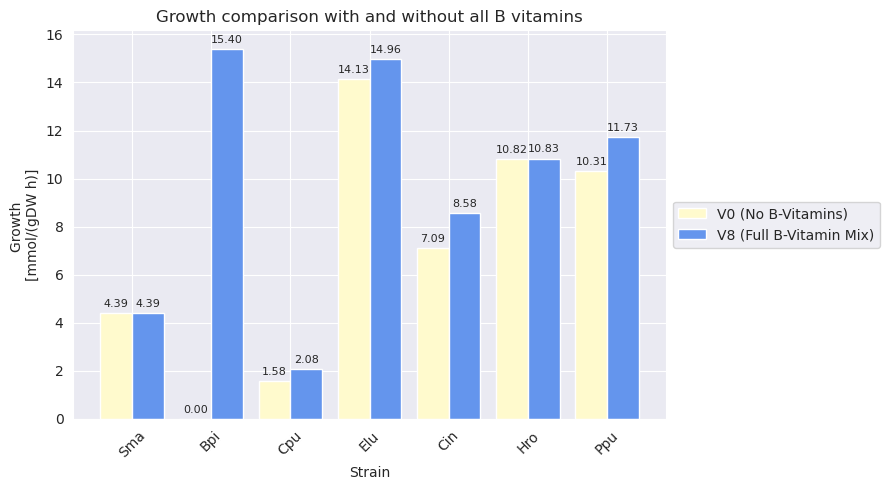

In [114]:
vitamin_growth_plots(models_vit, medium_for_vitaminTesting, EX_V8)

Bpi boosted its growth a bit more (~0.8); for Elu it is the first time we see a growth boost.
Cin and Ppu only + 0.01. \
Sma doesnt care, Cpu & Hro also no differences \
AA1 (Sma) doesnt have some of the vitamins in _c

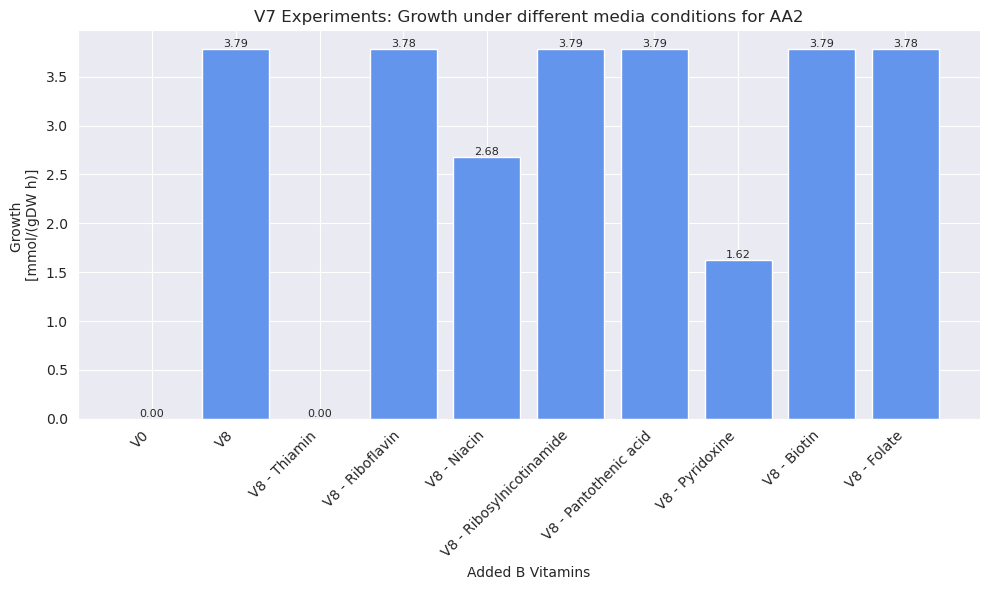

In [116]:
get_v7_growth(AA2_v, "V7", ala, EX_V8, EX_V8_names)

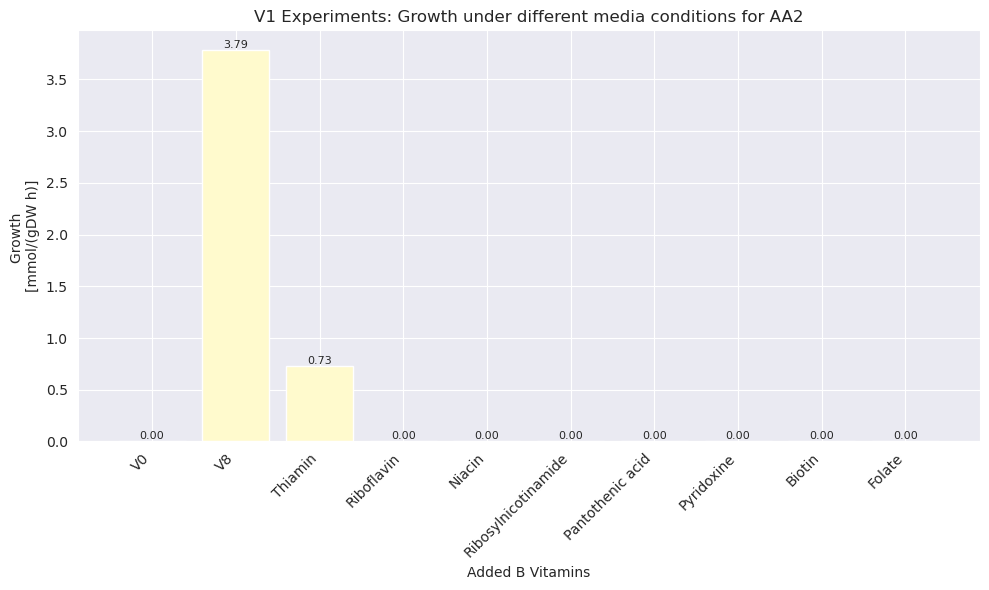

In [122]:
get_v1_growth(AA2_v, "V1", ala, EX_V8, EX_V8_names)

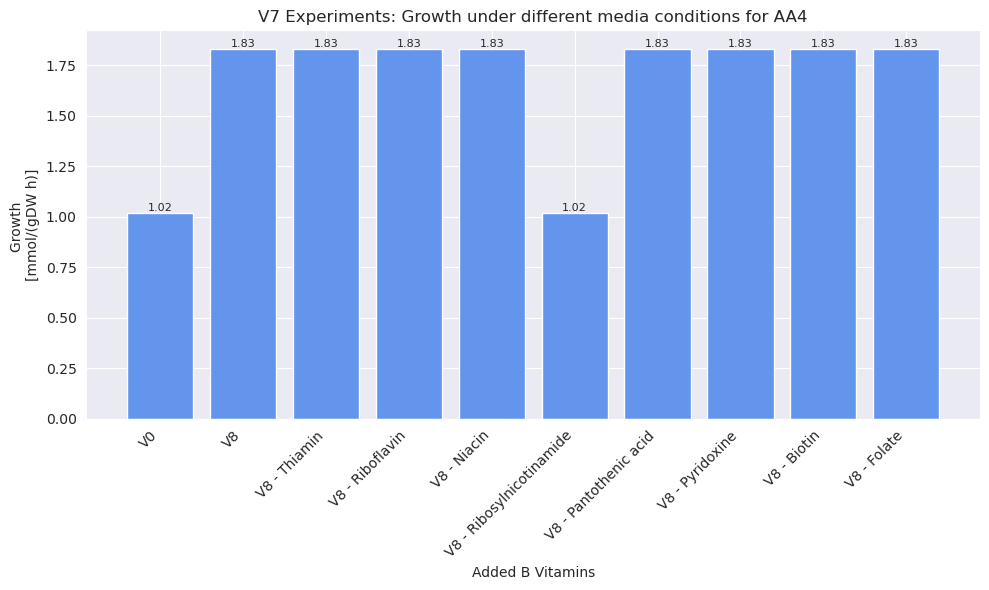

In [125]:
get_v7_growth(AA4_v, "V7", glu, EX_V8, EX_V8_names)

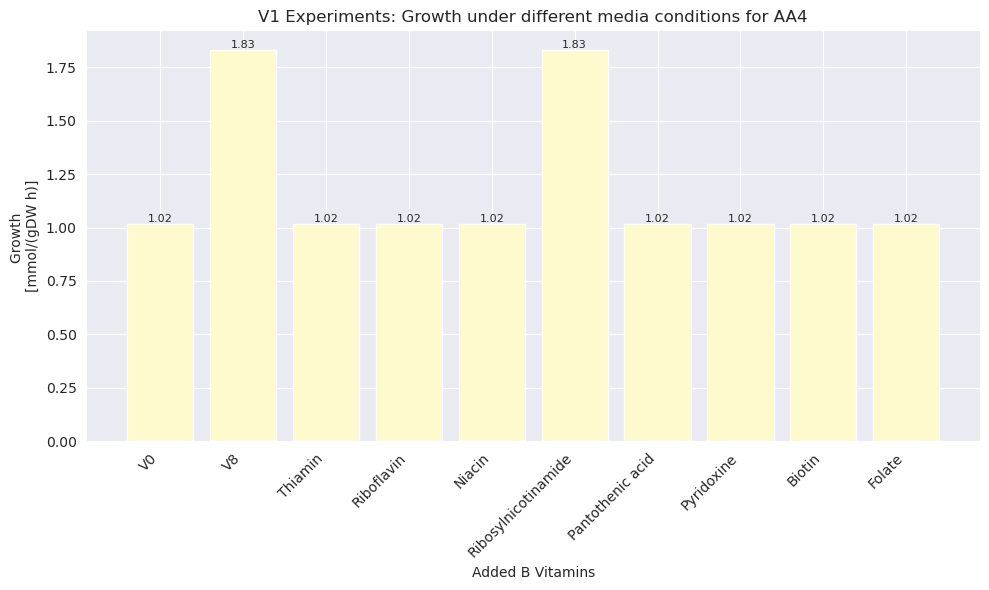

In [133]:
get_v1_growth(AA4_v, "V1", glu, EX_V8, EX_V8_names)

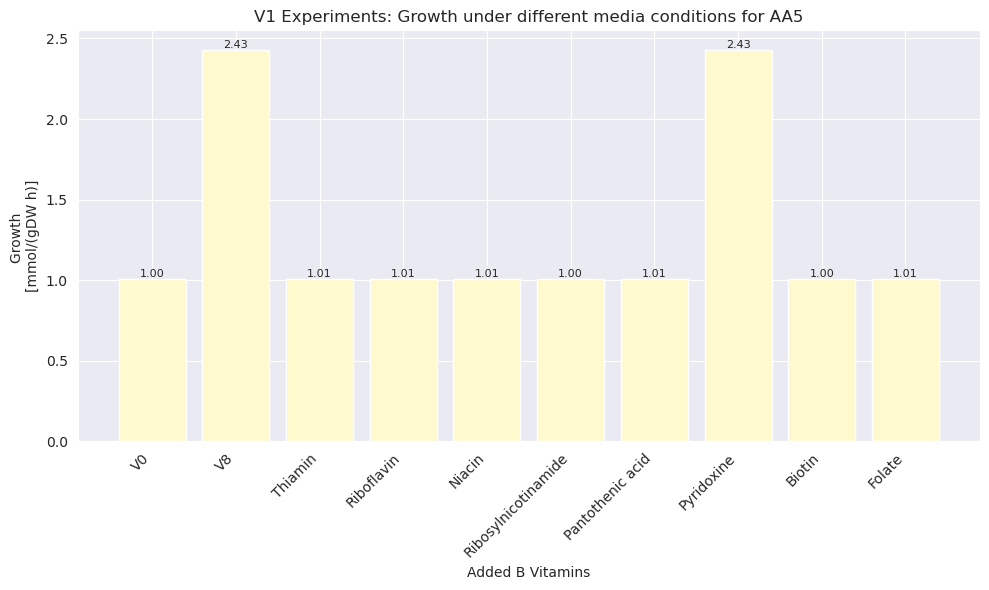

In [142]:
get_v1_growth(AA5_v, "V1", glu, EX_V8, EX_V8_names)

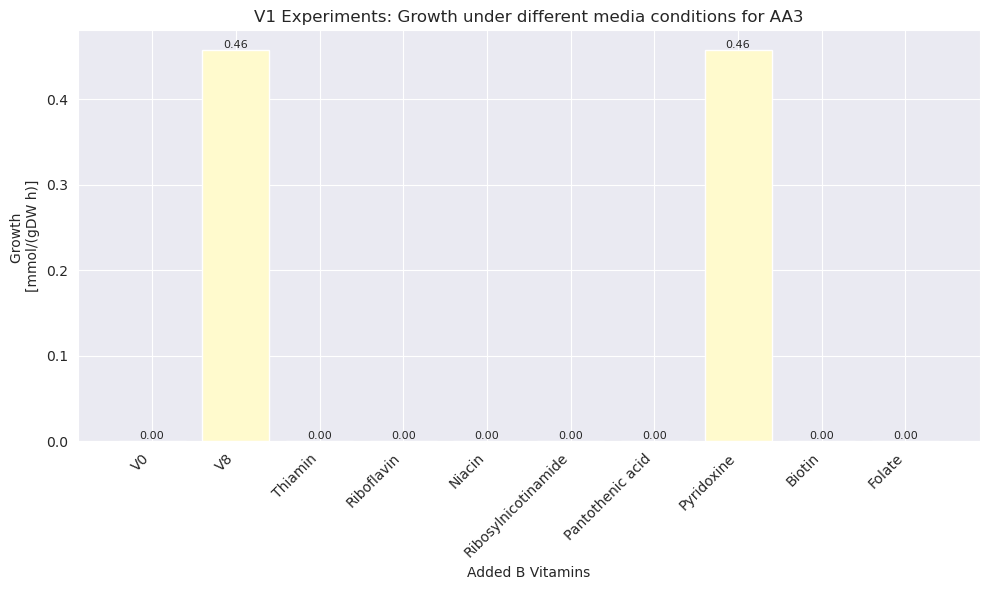

In [146]:
get_v1_growth(AA3, "V1", ala, EX_V8, EX_V8_names) # AA3 uses the vitamin basically just as a carbon source